In [1]:
%matplotlib inline 

import requests 
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
from __future__ import division
import matplotlib
import holidays
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
for date, name in sorted(holidays.DE(state='BE', years=2019).items()):
  print(date, name)

In [ ]:
for date, name in sorted(holidays.DE(state='BE', years=2020).items()):
  print(date, name)

In [26]:
############################# Put together data sets of 2019 and 2020. Construct additional feauters
holidays_2019_2020 = ['2019-01-01', '2019-04-19', '2019-04-22', '2019-05-01', '2019-05-30', '2019-06-10', '2019-10-03', '2019-12-25', '2019-12-26', '2020-01-01']
years = ['2019', '2020']
# 1-4
loads = range(1,5)
# 150,117,58,30
ids = [150, 117, 58, 30]
for load, id in zip(loads, ids):
    input_data = pd.DataFrame()
    raw_watt_2019 = pd.read_csv(f'load_profiles/sim_load_profiles_watt/load_{load}/load_profile_id={id}_{years[0]}_watt.csv')
    raw_watt_2020 = pd.read_csv(f'load_profiles/sim_load_profiles_watt/load_{load}/load_profile_id={id}_{years[1]}_watt.csv')
    raw_weather_2019 = pd.read_csv(f'weather_data/house_{load}/weather_id={id}_{years[0]}_15min.csv')
    raw_weather_2020 = pd.read_csv(f'weather_data/house_{load}/weather_id={id}_{years[1]}_15min.csv')
    input_data['interval'] = raw_watt_2019['interval'].append(raw_watt_2020['interval'])
    input_data['Power (W)'] = raw_watt_2019['Power (W)'].append(raw_watt_2020['Power (W)'])
    #input_data['temperature'] = raw_weather_2019['temperature'].append(raw_weather_2020['temperature'].head(2976))
    
    input_data['interval'] = input_data['interval'].apply(lambda timestamp: pd.to_datetime(timestamp, format='%Y-%m-%dT%H:%M'))
    input_data['weekday'] = input_data['interval'].dt.dayofweek
    input_data['month'] = input_data['interval'].dt.month
    input_data['hour_day'] = input_data['interval'].dt.hour
    input_data['day_type'] = np.zeros(len(input_data))
    input_data.loc[input_data['weekday'] == 5, 'day_type'] = 1.0
    input_data.loc[input_data['weekday'] == 6, 'day_type'] = 1.0
    
    input_data = input_data.set_index('interval')
    for day in holidays_2019_2020:
        input_data.loc[day: day, 'day_type'] = 1.0
        
    input_data.reset_index(inplace=True)
    input_data.to_csv(f'load_forecast_data/energy_load_id={id}_load_{load}.csv', index=True)
#input_data.info()
input_data

,interval,Power (W),weekday,month,hour_day,day_type
0,2019-01-01 00:00:00,148.660406,1,1,0,1.0
1,2019-01-01 00:15:00,189.966140,1,1,0,1.0
2,2019-01-01 00:30:00,173.331514,1,1,0,1.0
3,2019-01-01 00:45:00,193.476714,1,1,0,1.0
4,2019-01-01 01:00:00,148.027634,1,1,1,1.0
...,...,...,...,...,...,...
38011,2020-01-31 22:45:00,301.594777,4,1,22,0.0
38012,2020-01-31 23:00:00,301.594776,4,1,23,0.0
38013,2020-01-31 23:15:00,301.594776,4,1,23,0.0
38014,2020-01-31 23:30:00,301.594776,4,1,23,0.0


In [16]:
data = pd.read_csv('load_forecast_data/energy_load_id=30_load_4.csv')
corr_weekday = data['Power (W)'].corr(data['weekday'])
corr_month = data['Power (W)'].corr(data['month'])
corr_hour_day = data['Power (W)'].corr(data['hour_day'])
corr_day_type = data['Power (W)'].corr(data['day_type'])

print(f'Weekday: {corr_weekday}')
print(f'Month: {corr_month}')
print(f'Hour_day: {corr_hour_day}')
print(f'Day_type: {corr_day_type}')

Weekday: 0.030068541600207596
Month: 0.03173103778677121
Hour_day: 0.14150311502095836
Day_type: 0.028364853727424696


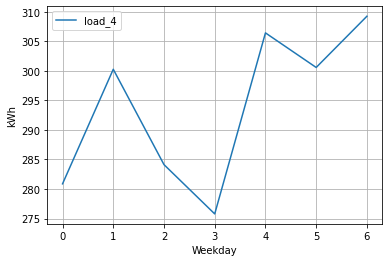

In [97]:
data = pd.read_csv('load_forecast_data/energy_load_id=30_load_4.csv')
data['interval'] = pd.to_datetime(data['interval'])
data = data.set_index('interval')
data = data.groupby(['weekday']).mean()
data.plot(kind='line', y='Power (W)', grid=True, label='load_4', ylabel='kWh', xlabel='Weekday')
plt.xticks(np.arange(1,13, 1))
plt.savefig('data_verification/load_forecast/load_forecast_weekday.pdf',bbox_inches='tight')


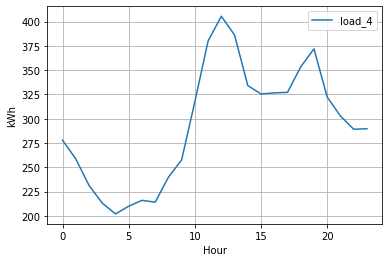

In [98]:
data = pd.read_csv('load_forecast_data/energy_load_id=30_load_4.csv')
data['interval'] = pd.to_datetime(data['interval'])
data = data.set_index('interval')
data = data.groupby(['hour_day']).mean()
data.plot(kind='line', y='Power (W)', grid=True, label='load_4', ylabel='kWh', xlabel='Hour')
plt.savefig('data_verification/load_forecast/load_forecast_hour.pdf',bbox_inches='tight')

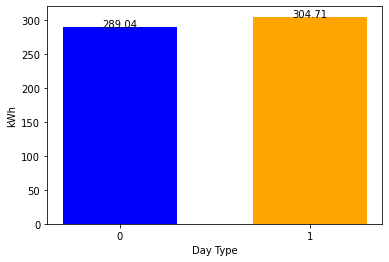

In [100]:
data = pd.read_csv('load_forecast_data/energy_load_id=30_load_4.csv')
data['interval'] = pd.to_datetime(data['interval'])
data = data.set_index('interval')
data = data.groupby(['day_type']).mean()

binary = ['0','1']
avg_power = data['Power (W)'].values
avg_power =  [round(x,2) for x in avg_power] 
plt.bar(binary,avg_power, color=['blue','orange'], width=0.6, align='center')

plt.xlabel('Day Type')
plt.ylabel('kWh')
for i in range(len(binary)):
    plt.text(i,avg_power[i],avg_power[i], ha = 'center')
#plt.show()
plt.savefig('data_verification/load_forecast/load_forecast_day_type.pdf',bbox_inches='tight')

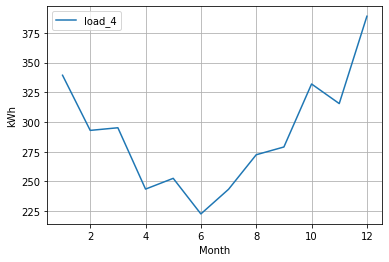

In [94]:
data = pd.read_csv('load_forecast_data/energy_load_id=30_load_4.csv')
data['interval'] = pd.to_datetime(data['interval'])
data = data.set_index('interval')
data = data.groupby(['month']).mean()
data.plot(kind='line', y='Power (W)', grid=True, label='load_4', ylabel='kWh', xlabel='Month')
plt.savefig('data_verification/load_forecast/load_forecast_month.pdf',bbox_inches='tight')

In [2]:
data = pd.read_csv('load_forecast_data/energy_load_id=30_load_4.csv')
# Split into X and y
#X = data[['Power (W)', 'weekday', 'month', 'hour_day', 'day_type']].values # input
X = data[['Power (W)']].values # input
y = data[['Power (W)']].values # only predict energy consumption
# Ensure all data is float
#values = values.astype('float32')
# Scale the data
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

window = 1 # or lag, input of how many previous data points used to predict 
train_length = 28032 # 80% of 2019
total_length = 38016 # 2019 & Jan 2020
test_end = 35040 # 2019

def slice_data(data, fr, to, name):
    result = data[fr:to,:]
    # Check shape
    print(name + ": start at " + str(fr) + " - shape: " + str(result.shape))
    return result

# Adjust y (y starts [window] after X)
n_features = X.shape[1]
print(n_features)
trainX = slice_data(X, 0, test_end, 'x') # 0 to 28032
trainy = slice_data(y, window, (test_end+window), 'y') # 1 to 28033, depending on the window
# Reshape in 3D input format
trainX = np.reshape(trainX, (trainX.shape[0], window, n_features))
print(trainX.shape, trainy.shape)

1
x: start at 0 - shape: (35040, 1)
y: start at 1 - shape: (35040, 1)
(35040, 1, 1) (35040, 1)


Epoch 1/50
28/28 [==============================] - 3s 25ms/step - loss: 0.9146 - val_loss: 1.0132
Epoch 2/50
28/28 [==============================] - 0s 11ms/step - loss: 0.8820 - val_loss: 0.9518
Epoch 3/50
28/28 [==============================] - 0s 11ms/step - loss: 0.8375 - val_loss: 0.8738
Epoch 4/50
28/28 [==============================] - 0s 12ms/step - loss: 0.7852 - val_loss: 0.7933
Epoch 5/50
28/28 [==============================] - 0s 11ms/step - loss: 0.7377 - val_loss: 0.7309
Epoch 6/50
28/28 [==============================] - 0s 12ms/step - loss: 0.7073 - val_loss: 0.6978
Epoch 7/50
28/28 [==============================] - 0s 10ms/step - loss: 0.6946 - val_loss: 0.6859
Epoch 8/50
28/28 [==============================] - 0s 11ms/step - loss: 0.6914 - val_loss: 0.6829
Epoch 9/50
28/28 [==============================] - 0s 11ms/step - loss: 0.6909 - val_loss: 0.6819
Epoch 10/50
28/28 [==============================] - 0s 11ms/step - loss: 0.6908 - val_loss: 0.6816
Epoch 11/

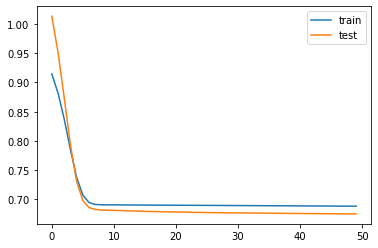

Test MSE: 56429.785
Test RMSE: 237.550


In [3]:
""" Simple model """
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
model.compile(loss="mse", optimizer="adam")
#model.summary()

# fit network
history = model.fit(trainX, trainy, epochs=50, batch_size=1024, validation_split=0.2, verbose=1, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.layers import concatenate

# Predict values for Jan 2020
# Prepare input 
forecastX = X[test_end-window:total_length-window]
# Prepare real energy consumption
real_y = y[test_end:]
# Reshape to required format and predict
forecastX = np.reshape(forecastX, (forecastX.shape[0], window, n_features))
forecasted_y = model.predict(forecastX)
# invert scaling
inv_yhat = scaler.inverse_transform(forecasted_y)
inv_y = scaler.inverse_transform(real_y)
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)

Epoch 1/50
28/28 [==============================] - 9s 60ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 2/50
28/28 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 3/50
28/28 [==============================] - 1s 34ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 4/50
28/28 [==============================] - 1s 34ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 5/50
28/28 [==============================] - 1s 39ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 6/50
28/28 [==============================] - 1s 32ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 7/50
28/28 [==============================] - 1s 31ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/50
28/28 [==============================] - 1s 31ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/50
28/28 [==============================] - 1s 32ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/50
28/28 [==============================] - 1s 37ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 11/

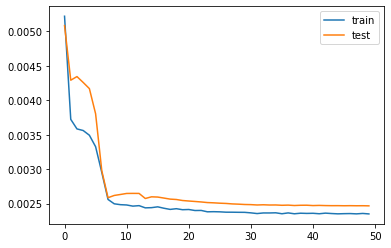

Test MSE: 54346.458
Test RMSE: 233.123


In [3]:
""" Complex model2 """
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

dropout = 0.2
model2 = Sequential()
model2.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model2.add(Dropout(dropout))
model2.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model2.add(Dropout(dropout))
model2.add(Dense(16, activation="relu", kernel_initializer="uniform"))
model2.add(Dense(1, activation="relu", kernel_initializer="uniform"))
model2.compile(loss="mse", optimizer="adam")
#model2.summary()

# fit network
history2 = model2.fit(trainX, trainy, epochs=50, batch_size=1024, validation_split=0.2, verbose=1, shuffle=False)

# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.layers import concatenate

# Predict values for Jan 2020
# Prepare input 
forecastX2 = X[test_end-window:total_length-window]
# Prepare real energy consumption
real_y2 = y[test_end:]
# Reshape to required format and predict
forecastX2 = np.reshape(forecastX2, (forecastX2.shape[0], window, n_features))
forecasted_y2 = model2.predict(forecastX2)
# invert scaling
inv_yhat2 = scaler.inverse_transform(forecasted_y2)
inv_y2 = scaler.inverse_transform(real_y2)
# calculate MSE & RMSE
mse2 = mean_squared_error(inv_y2, inv_yhat2)
rmse2 = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Test MSE: %.3f' % mse2)
print('Test RMSE: %.3f' % rmse2)

In [19]:
del model, model2

NameError: name 'model' is not defined

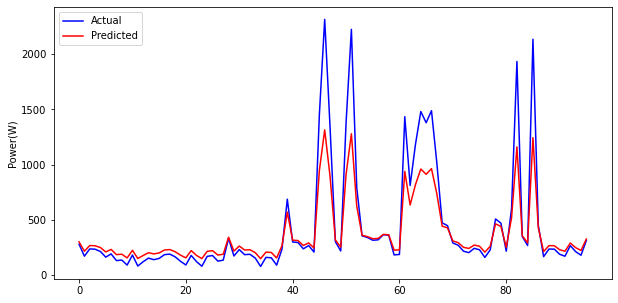

In [14]:
steps = 96
start = 1344
plt.figure(figsize=(10, 5))
plt.plot(inv_y2[start:start+steps], label='Actual', color="blue")
plt.plot(inv_yhat2[start+1:start+steps+1], label='Predicted', color="red")
plt.ylabel("Power(W)")
#plt.title("Actual Vs Predicted Results")
plt.legend()
plt.savefig('data_verification/load_forecast/chunk_15stJan_2020.pdf',bbox_inches='tight')
#plt.show()

In [25]:
df = pd.DataFrame()
df['interval'] = (pd.DataFrame(columns=['INTERVAL'],
                  index=pd.date_range('2020-01-01T00:00:00Z', '2020-01-31T23:45:00Z',
                                      freq='15T'))
       #.between_time('0:00','23:59')
       .index.strftime('%Y-%m-%dT%H:%M')
       .tolist()
        )
#df['Actual'] = inv_y2
df['Power (W)'] = inv_yhat2
#df
df.to_csv('load_forecast_data/forecast_load_d3a_format/load_forecast_id=30_load=4.csv', index=False)

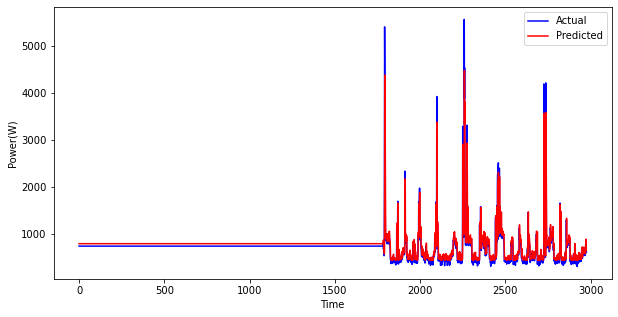

In [20]:
actual = pd.read_csv('load_forecast_data/energy_load_id=150_load_1.csv')
actual = actual['Power (W)'].tail(2976).values
predicted = pd.read_csv('load_forecast_data/forecast_load_d3a_format/load_forecast_id=150_load=1.csv')
#predicted = predicted['Power (W)'].values
predicted['actual'] = actual
steps = 2976
plt.figure(figsize=(10, 5))
plt.plot(predicted['actual'][:steps], label='Actual', color="blue")
plt.plot(predicted['Power (W)'][:steps], label='Predicted', color="red")
#plt.xticks(index)
plt.xlabel('Time')
plt.ylabel("Power(W)")
#plt.title("Forecast January 2020: Load 4")
plt.legend()
plt.savefig('data_verification/load_forecast/load_result_load1.pdf',bbox_inches='tight')
#plt.show()